# skew-T script that accesses data from University of Wyoming servers.

In [1]:
"""
This code was developed from skew-T examples provided in MetPy from NSF Unidata.
Originally modified from https://unidata.github.io/python-training/gallery/skewt_example/
Updates such as parameter printing drawn from student suggestions when WAF2 was delivered in Spring 2024.
Last updated 29 January 2025 by Kim Wood.
"""

'\nThis code was developed from skew-T examples provided in MetPy from NSF Unidata.\nOriginally modified from https://unidata.github.io/python-training/gallery/skewt_example/\nUpdates such as parameter printing drawn from student suggestions when WAF2 was delivered in Spring 2024.\nLast updated 29 January 2025 by Kim Wood.\n'

In [2]:
%matplotlib inline

In [3]:
from datetime import datetime
from metpy.plots import SkewT, Hodograph
from metpy.units import pandas_dataframe_to_unit_arrays, units
from scipy.interpolate import interp1d
from siphon.simplewebservice.wyoming import WyomingUpperAir
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import pandas as pd
import requests

Provide your desired station (3-letter identifier in all caps) and date + time in UTC.<br />
You can also adjust boolean (True/False) settings for plotting a parcel path.<br />
Note that, as currently written, a parcel always starts from the surface.

In [4]:
station = 'JAN'            # examples: JAN, TUS
date = '2023032412'        # example: 2023033112 = 12 UTC 31 March 2023)
plotParcelPath = False     # True = plots parcel path   False = disables
mixedParcel = False        # True = the plotted parcel path is for a mixed-layer parcel    False = disables
surfaceParcel = False      # True = the plotted parcel path is for a surface parcel        False = disables
mixedLayerDepth = 100.     # Depth of mixed layer for parcel in hPa

Assuming the Wyoming server is working <strong>OR</strong> you have a local skew-T data file, it shouldn't be necessary to change any of the below code.

In [5]:
#### Obtain sounding data.
dt = datetime.strptime(date, '%Y%m%d%H')
try:
    ## Pull data from the University of Wyoming server
    df = WyomingUpperAir.request_data(dt, station)
    data = pandas_dataframe_to_unit_arrays(df)
    p = data['pressure']
    end = max(np.where(p.m>95.)[0]) + 1  # limit data to pressure levels >= 95 hPa
    p = data['pressure'][0:end]
    T = data['temperature'][0:end]
    Td = data['dewpoint'][0:end]
    u = data['u_wind'][0:end]
    v = data['v_wind'][0:end]
    hgt = data['height'][0:end]
except requests.exceptions.HTTPError:
    ## Look for local data
    #    columns: PRES HGHT TEMP DWPT RELH MIXR DRCT SKNT THTA THTE THTV
    #    units:   hPa  m    C    C    %    g/kg deg  kt   K    K    K
    #    index:   0:6  6:12
    fname = 'uwyo_%s_%s.txt' % (station,date)
    a = open(fname, 'r')
    info = np.array([line.strip('\n') for line in a])  # preserves whitespace on each line
    a.close()
    p = []
    T = []
    Td = []
    u = []
    v = []
    hgt = []
    for i in range(6,info.size):
        value = float(info[i][0:8].strip())       # pressure [hPa]
        if value <= 95.:
            break
        mrr = info[i].split()
        if len(mrr) < 11:
            ## handle missing values!
            p.append(value)
            if len(info[i][8:15].strip()) > 0:
                hgt.append(float(info[i][8:15]))  # height [m]
            else:
                hgt.append(np.nan)
            if len(info[i][15:22].strip()) > 0:
                T.append(float(info[i][15:22]))   # temperature [degC]
            else:
                T.append(np.nan)
            if len(info[i][22:29].strip()) > 0:
                Td.append(float(info[i][22:29]))  # dewpoint temperature [degC]
            else:
                Td.append(np.nan)
            if len(info[i][43:50].strip()) > 0 and len(info[i][50:57].strip()) > 0:
                speed = float(info[i][50:57].strip()) * units('kt')
                direction = float(info[i][43:50].strip()) * units('degrees')
                zonal, meridional = mpcalc.wind_components(speed, direction)
                u.append(zonal.m)
                v.append(meridional.m)
            else:
                u.append(np.nan)
                v.append(np.nan)
        else:
            p.append(float(mrr[0]))
            hgt.append(float(mrr[1]))
            T.append(float(mrr[2]))
            Td.append(float(mrr[3]))
            speed = float(mrr[7]) * units('kt')
            direction = float(mrr[6]) * units('degrees')
            zonal, meridional = mpcalc.wind_components(speed, direction)
            u.append(zonal.m)
            v.append(meridional.m)
    p = p * units('hPa')
    T = T * units('degC')
    Td = Td * units('degC')
    u = u * units('kt')
    v = v * units('kt')
    hgt = hgt * units('m')

In [6]:
#### Do a data quality check for repeated height and/or pressure values (which can break the script's plotting)
check = np.ediff1d(p.m)
if check.min() <= 0.:
    bad = np.where(check==0)[0]
    if len(bad) > 0:
        p_new = np.delete(p.m, bad)
        p = p_new * data['pressure'].units  # assign proper units to the corrected 'pressure' array
        T_new = np.delete(T.m, bad)
        T = T_new * data['temperature'].units  # assign proper units to the corrected 'temperature' array
        Td_new = np.delete(Td.m, bad)
        Td = Td_new * data['dewpoint'].units  # assign proper units to the corrected 'dewpoint' array
        u_new = np.delete(u.m, bad)
        u = u_new * data['u_wind'].units  # assign proper units to the corrected 'u_wind' array
        v_new = np.delete(v.m, bad)
        v = v_new * data['v_wind'].units  # assign proper units to the corrected 'v_wind' array
        hgt_new = np.delete(hgt.m, bad)
        hgt = hgt_new * data['height'].units  # assign proper units to the corrected 'height' array

#### Define display ranges for temperature and pressure
Tmin, Tmax = [-50, 50]
Pmax, Pmin = [1020, 100]

#### Figure out where to plot temperature labels on isotherms for the given T and P display ranges
TT = np.arange(Tmax-10,-121,-10)
LL = np.logspace(np.log10(850), np.log10(Pmin+20), num=TT.size, endpoint=True, base=10.)

#### Compute dewpoint values for desired saturation mixing ratio lines (to plot from 1000 to 500 hPa)
pressure = np.arange(1000, 499, -50) * units('hPa')
mixing_ratio = np.array([1, 2, 4, 6, 8, 10, 13, 16, 20, 25, 30, 36, 42]).reshape(-1, 1) * units('g/kg')
plotTd = mpcalc.dewpoint(mpcalc.vapor_pressure(pressure, mixing_ratio))

In [7]:
#### Compute various parameters if a parcel path is desired
parcel_prof = None
if plotParcelPath is True:
    if surfaceParcel is True:
        parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
        lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
        lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td, parcel_prof, Td[0])
        mixT, mixTd = [T[0], Td[0]]  # for later use
        LI = mpcalc.lifted_index(p, T, parcel_prof)
        CAPE, CIN = mpcalc.cape_cin(p, T, Td, parcel_prof, which_lfc='bottom', which_el='top')
        if mixedParcel is True:
            ## Save above parameters with '_sfc' variable names
            ## (not the cleanest method, but it does the job)
            parcel_prof_sfc = parcel_prof.copy()
            lcl_pressure_sfc, lcl_temperature_sfc = [lcl_pressure.copy(), lcl_temperature.copy()]
            lfc_pressure_sfc, lfc_temperature_sfc = [lfc_pressure.copy(), lfc_temperature.copy()]
            mixT_sfc, mixTd_sfc = [mixT.copy(), mixTd.copy()]
            LI_sfc, CAPE_sfc, CIN_sfc = [LI, CAPE, CIN]
    elif mixedParcel is True:
        ## Compute mixed-layer parcel characteristics, then bring down to surface pressure
        ref_T, ref_Td = mpcalc.mixed_layer(p, T, Td, depth=mixedLayerDepth*units('hPa'))
        ref_p = p.m[0] - (float(mixedLayerDepth)/2.)  # midpoint of mixed layer in hPa
        mixT = (ref_T.m * (p.m[0]/ref_p)**(287./1004.)) * units('degC')  # follow dry adiabat to surface P
        q = mpcalc.specific_humidity_from_dewpoint(ref_p*units('hPa'), ref_Td)
        mixTd = mpcalc.dewpoint_from_specific_humidity(p[0], mixT, q)  # compute Td using surface P and above q
        ## Now compute mixed-layer parcel profile and related parameters
        parcel_prof = mpcalc.parcel_profile(p, mixT, mixTd).to('degC')
        lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], mixT, mixTd)
        lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td, parcel_prof, mixTd)
        LI = mpcalc.lifted_index(p, T, parcel_prof)
        CAPE, CIN = mpcalc.cape_cin(p, T, Td, parcel_prof, which_lfc='bottom', which_el='top')

Everything below this point is for plotting purposes.

<>:163: SyntaxWarning: invalid escape sequence '\ '
<>:165: SyntaxWarning: invalid escape sequence '\ '
<>:167: SyntaxWarning: invalid escape sequence '\ '
<>:169: SyntaxWarning: invalid escape sequence '\ '
<>:163: SyntaxWarning: invalid escape sequence '\ '
<>:165: SyntaxWarning: invalid escape sequence '\ '
<>:167: SyntaxWarning: invalid escape sequence '\ '
<>:169: SyntaxWarning: invalid escape sequence '\ '
C:\Users\roswe\AppData\Local\Temp\ipykernel_7112\1716029138.py:163: SyntaxWarning: invalid escape sequence '\ '
  pwat_str = 'PWAT: ' + r'$\bf{' + '%.1f\ mm\ (%.2f\ in.)' % (pwat.m, pwat.to('inch').m) + '}$\n'
C:\Users\roswe\AppData\Local\Temp\ipykernel_7112\1716029138.py:165: SyntaxWarning: invalid escape sequence '\ '
  shear1 = 'sfc-1 km shear: ' + r'$\bf{' + '%d\ kt' % np.sqrt(ushr**2.+vshr**2.).m + '}$\n'
C:\Users\roswe\AppData\Local\Temp\ipykernel_7112\1716029138.py:167: SyntaxWarning: invalid escape sequence '\ '
  shear3 = 'sfc-3 km shear: ' + r'$\bf{' + '%d\ kt' % np.s

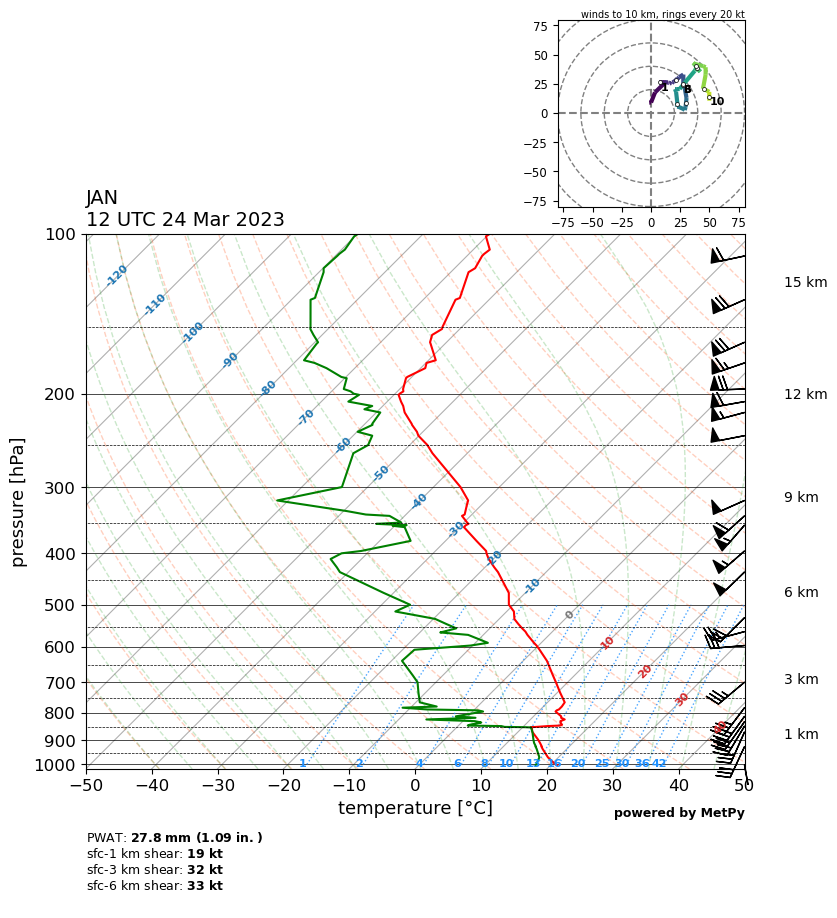

In [8]:
#### Create the figure and skew-T diagram (sized for letter paper to be able to print)
fig = plt.figure(figsize=(8.5, 11))
skew = SkewT(fig, rotation=45)
skew.ax.set_xlim(Tmin, Tmax)
skew.ax.set_ylim(Pmax, Pmin)
if plotParcelPath is True:
    if surfaceParcel is True and mixedParcel is True:
        skew.plot(p, parcel_prof, 'k', linewidth=0.75)                      # mixed parcel path is solid
        skew.plot(p, parcel_prof_sfc, 'k', linewidth=0.75, linestyle='--')  # surface parcel path is dashed
    elif surfaceParcel is True and mixedParcel is False:
        skew.plot(p, parcel_prof, 'k', linewidth=0.75, linestyle='--')
    elif surfaceParcel is False and mixedParcel is True:
        skew.plot(p, parcel_prof, 'k', linewidth=0.75)

#### Add data to skew-T plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
end = np.where(p.m>=100.)[0][-1]  # grab the LAST index value from 'p' with values at or above 100 hPa
skew.plot_barbs(p[:end:4], u[:end:4], v[:end:4], y_clip_radius=0.03)  # plot every 4th wind barb
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K, alpha=0.25, colors='orangered', linewidths=1)
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K, alpha=0.25, colors='tab:green', linewidths=1)
skew.plot_mixing_lines(pressure=pressure, mixing_ratio=mixing_ratio, linestyles='dotted', colors='dodgerblue',
                       linewidths=1)
skew.ax.grid(axis='y', c='k', lw=0.5)
for l in range(150,951,100):
    ## This for loop adds dashed horizontal lines for pressure levels at 950 hPa, 850 hPa, etc.
    pp = l * np.ones(10)
    tt = np.linspace(-120,50,10)
    skew.plot(pp, tt, c='k', ls='--', lw=0.5)

#### Add some additional plot features (change tick label sizes, add x- and y-axis labels, add a title)
plt.xticks(fontsize=12)
plt.xlabel('temperature [\N{DEGREE SIGN}C]', fontsize=13)
plt.yticks(fontsize=12)
plt.ylabel('pressure [hPa]', fontsize=13)
plt.title(station+'\n'+dt.strftime('%H UTC %d %b %Y'), loc='left', size=14)

#### Consistently position 'powered by MetPy' label
bbox = skew.ax.get_position()
skew.ax.set_position([bbox.x0, bbox.y0-0.06, bbox.width, bbox.height])  # shift skew-T downward for hodograph
bbox = skew.ax.get_position()  # update 'bbox' values based on previous line
x = bbox.x1
y = bbox.y0 - 0.04
skew.ax.text(x, y, 'powered by MetPy', size=9, weight='bold', ha='right', va='center', transform=fig.transFigure)

#### Add isotherm labels
for i in range(TT.size):
    if TT[i] > 0.:
        color = 'tab:red'
    elif TT[i] == 0.:
        color = '#777777'
    else:
        color = 'tab:blue'
    skew.ax.text(TT[i], LL[i], '%d'%TT[i], ha='center', va='center', weight='bold', color=color, size=8,
                 rotation=45)

#### Add saturation mixing ratio labels
ll0 = max(skew.ax.get_ylim())
for i in range(mixing_ratio.m.size):
    if plotTd.m[i,0] > Tmax or plotTd.m[i,0] < Tmin:
        continue
    skew.ax.text(plotTd.m[i,0], ll0, '%d'%mixing_ratio.m[i,0], ha='center', va='bottom', weight='bold', size=8,
                 color='dodgerblue')

#### Compute height reference levels and other parameters of interest                                                   ref_hgt = hgt.m - hgt.m[0]
ref_hgt = hgt.m - hgt.m[0]
h_km = np.array(ref_hgt, dtype=float) / 1000.  # convert to float numbers and divide by 1000 to get km
km = np.arange(1.,11.,1.)
stop = max(np.where(ref_hgt<=10000.)[0]) + 2  # display hodograph below 10 km
u_ref = interp1d(h_km[0:stop+2], u[0:stop+2], kind='linear')(km)
v_ref = interp1d(h_km[0:stop+2], v[0:stop+2], kind='linear')(km)
pwat = mpcalc.precipitable_water(p, Td)
T_ref_z = interp1d(h_km[0:stop+2], T[0:stop+2], kind='linear')(km)
ref_p = np.arange(900.,499.,-50.)
T_ref_p = interp1d(p[0:stop+2], T[0:stop+2], kind='linear')(ref_p)

#### Identify the location of desired reference altitudes for the input data (1 km, 3 km, 6 km, 12 km, 15 km)
ref_levels = [1., 3., 6., 9., 12., 15.]
check = np.ediff1d(h_km)
if check.min() <= 0.:
    ## Handle soundings that have bad height values
    rows = np.where(check<=0.)[0]
    h_km = h_km[0:rows[0]]
    p_for_interp = p.m[0:rows[0]]
else:
    p_for_interp = p.m

#### Add height labels found above
for z in ref_levels:
    try:
        ref_p = interp1d(h_km, p_for_interp, kind='linear')(z)
        skew.ax.text(1.06, ref_p, '%d km'%z, transform=skew.ax.get_yaxis_transform(which='tick2'))
    except ValueError:
        continue

#### Print parcel parameter values above skew-T diagram
if plotParcelPath is True:
    if (surfaceParcel is True and mixedParcel is False) or (surfaceParcel is False and mixedParcel is True):
        if surfaceParcel is True:
            title = 'surface-based parcel'
        else:
            title = '%d-hPa mixed layer parcel' % mixedLayerDepth
        #### Add parameter text
        string = '\nT: %.1f\N{DEGREE SIGN}C    Td: %.1f\N{DEGREE SIGN}C'%(mixT.m,mixTd.m)
        if str(np.isnan(lcl_pressure.m)) == 'True':
            string += '    LCL: N/A'
        else:
            string += '    LCL: %.1f hPa' % lcl_pressure.m
        if str(np.isnan(lfc_pressure.m)) == 'True':
            string += '    LFC: N/A'
        else:
            string += '    LFC: %.1f hPa' % lfc_pressure.m
        LI_val = LI.m
        if isinstance(LI.m, np.float64) is False:
            LI_val = LI.m.item()  # why is this a 1-element array??
        string += '\nCAPE: %.1f J/kg    CIN: %.1f J/kg    LI: %.1f' % (CAPE.m,CIN.m,LI_val)
        x = bbox.x0
        y = bbox.y1 + 0.11
        skew.ax.text(x, y, title, ha='left', va='top', size=9, weight='bold', transform=fig.transFigure)
        skew.ax.text(x, y, string, ha='left', va='top', size=9, transform=fig.transFigure)
    elif surfaceParcel is True and mixedParcel is True:
        ## surface parameters first
        sfcString = '\nT: %.1f\N{DEGREE SIGN}C    Td: %.1f\N{DEGREE SIGN}C'%(mixT_sfc.m,mixTd_sfc.m)
        if str(np.isnan(lcl_pressure_sfc.m)) == 'True':
            sfcString += '    LCL: N/A'
        else:
            sfcString += '    LCL: %.1f hPa' % lcl_pressure_sfc.m
        if str(np.isnan(lfc_pressure_sfc.m)) == 'True':
            sfcString += '    LFC: N/A'
        else:
            sfcString += '    LFC: %.1f hPa' % lfc_pressure_sfc.m
        LI_val = LI_sfc.m
        if isinstance(LI_sfc.m, np.float64) is False:
            LI_val = LI_sfc.m.item()  # why is this a 1-element array??
        sfcString += '\nCAPE: %.1f J/kg    CIN: %.1f J/kg    LI: %.1f' % (CAPE_sfc.m,CIN_sfc.m,LI_val)
        print('surface-based parcel' + sfcString)
        x = bbox.x0
        y = bbox.y1 + 0.19
        skew.ax.text(x, y, 'surface-based parcel', ha='left', va='top', size=9, weight='bold', transform=fig.transFigure)
        skew.ax.text(x, y, sfcString, ha='left', va='top', size=9, transform=fig.transFigure)
        ## mixed-layer parameters next
        title = '%d-hPa mixed layer parcel' % mixedLayerDepth
        string = '\nT: %.1f\N{DEGREE SIGN}C    Td: %.1f\N{DEGREE SIGN}C'%(mixT.m,mixTd.m)
        if str(np.isnan(lcl_pressure.m)) == 'True':
            string += '    LCL: N/A'
        else:
            string += '    LCL: %.1f hPa' % lcl_pressure.m
        if str(np.isnan(lfc_pressure.m)) == 'True':
            string += '    LFC: N/A'
        else:
            string += '    LFC: %.1f hPa' % lfc_pressure.m
        LI_val = LI.m
        if isinstance(LI.m, np.float64) is False:
            LI_val = LI.m.item()  # why is this a 1-element array??
        string += '\nCAPE: %.1f J/kg    CIN: %.1f J/kg    LI: %.1f' % (CAPE.m,CIN.m,LI_val)
        print(title + string)
        x = bbox.x0
        y = bbox.y1 + 0.1 + 0.045
        skew.ax.text(x, y, title, ha='left', va='top', size=9, weight='bold', transform=fig.transFigure)
        skew.ax.text(x, y, string, ha='left', va='top', size=9, transform=fig.transFigure)

#### Print general parameter values below skew-T diagram
pwat_str = 'PWAT: ' + r'$\bf{' + '%.1f\ mm\ (%.2f\ in.)' % (pwat.m, pwat.to('inch').m) + '}$\n'
ushr, vshr = mpcalc.bulk_shear(p, u, v, height=ref_hgt*units('m'), bottom=0.*units('m'), depth=1000.*units('m'))
shear1 = 'sfc-1 km shear: ' + r'$\bf{' + '%d\ kt' % np.sqrt(ushr**2.+vshr**2.).m + '}$\n'
ushr, vshr = mpcalc.bulk_shear(p, u, v, height=ref_hgt*units('m'), bottom=0.*units('m'), depth=3000.*units('m'))
shear3 = 'sfc-3 km shear: ' + r'$\bf{' + '%d\ kt' % np.sqrt(ushr**2.+vshr**2.).m + '}$\n'
ushr, vshr = mpcalc.bulk_shear(p, u, v, height=ref_hgt*units('m'), bottom=0.*units('m'), depth=6000.*units('m'))
shear6 = 'sfc-6 km shear: ' + r'$\bf{' + '%d\ kt' % np.sqrt(ushr**2.+vshr**2.).m + '}$\n'
string = pwat_str + shear1 + shear3 + shear6
x = bbox.x0
y = bbox.y0 - 0.055
_ = skew.ax.text(x, y, string, size=9, ha='left', va='top', transform=fig.transFigure)

#### Add hodograph panel
ax2 = fig.add_axes([bbox.x1-0.22, bbox.y1, 0.22, 0.22])
h = Hodograph(ax2, component_range=80.)
h.add_grid(increment=20)
h.ax.set_xlim(-80,80)
h.ax.set_xticks(np.arange(-75,76,25))
h.ax.set_ylim(-80,80)
h.ax.set_yticks(np.arange(-75,76,25))
h.ax.tick_params(labelsize=8.5)
h.plot_colormapped(u[0:stop], v[0:stop], hgt[0:stop])
pos = h.ax.get_position()
h.ax.text(pos.x1, pos.y1, 'winds to 10 km, rings every 20 kt', transform=fig.transFigure, ha='right', va='bottom', size=7)
h.ax.scatter(u_ref, v_ref, s=8, c='w', edgecolor='k', linewidths=0.5, zorder=50)
for value in [1.,3.,6.,10.]:
    i = np.where(km==value)[0].item()
    h.ax.text(u_ref[i], v_ref[i], '%d'%km[i], ha='left', va='top', size=8, weight='bold', zorder=50)

#### Display skew-T diagram (uncomment one or both of the 'savefig()' lines to save the figure
#plt.savefig(station+dt.strftime('_%Y%m%d%H.png'), bbox_inches='tight', pad_inches=0.05)
plt.savefig(station+dt.strftime('_%Y%m%d%H.pdf'))
plt.show()  # comment this line if you don't want Python to display the plot